# analysis of 10x Visium data
In this practical, we will get to know the Python ecosystem for (spatial) data. We will work on a mouse brain data set from [Kleshchevnikov et al., 2022](https://doi.org/10.1038/s41587-021-01139-4). The data can be downloaded [here](https://cell2location.cog.sanger.ac.uk/tutorial/mouse_brain_visium_wo_cloupe_data.zip) (we will use only the ST8059048 sample).

Since some calculations take a lot of time or memory, we also provide precomputed results that we will use in this notebook. You can download a bundle of all required data and results [here](https://hub.dkfz.de/s/HEaCoDNqozPwJ8p).

## libraries and first impressions
Let's start by loading the required packages. [NumPy](https://www.numpy.org), [SciPy](https://www.scipy.org), [Matplotlib](https://matplotlib.org/) (and arguably [seaborn](https://seaborn.pydata.org/)) are the pillars of the scientific Python stack and belong on every scientist's computer. [AnnData](https://anndata.readthedocs.io) provides a container object that can hold the raw data, associated metadata, and transformed/analyzed data, such as pairwise distance matrices or embeddings. [Muon](https://gtca.github.io/muon/) builds on top of AnnData to provide a container for multimodal data. [Scanpy](https://scanpy.readthedocs.io) is the Python equivalent to Seurat. It works on AnnData objects and provides many preprocessing, analysis, and visualization methods. [SpatialData](https://spatialdata.scverse.org/) is a new package geared towards spatial data. It introduces a new container type and unified operations for all kinds of spatial data. It also provides interactive visualization using [Napari](https://napari.org). [SpatialDE](https://github.com/PMBio/SpatialDE) accepts [AnnData](https://anndata.readthedocs.io/) objects as well and can detect spatially variable genes as well as perform segmentation of tissue regions taking both gene expression and spatial coordinates into account. [Cell2location](https://github.com/BayraktarLab/cell2location), built on top of [scvi-tools](https://scvi-tools.org/) and [Pyro](http://pyro.ai/), also works with AnnData objects and can deconvolve array data using a single-cell reference with annotated cell types.

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad
import muon as mu
import scanpy as sc
import spatialdata as sd
import spatialdata_io
import spatialdata_plot
from napari_spatialdata import Interactive

import cell2location
from cell2location.utils.filtering import filter_genes
from cell2location.plt import plot_spatial
from cell2location.models import RegressionModel, Cell2location
import scvi
import mofapy2
import mofax

plt.rcParams["figure.figsize"] = (8, 8)

import SpatialDE

/home/ilia/Documents/Uni/Uni/PostDoc 2 Stegle/teaching/single cell course/venv/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ilia/Documents/Uni/Uni/PostDoc 2 Stegle/teaching/single cell course/venv/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for detail

SpatialData provides a handy function to read Visium data as it comes out of the 10x pipeline.

In [2]:
sdata = spatialdata_io.visium("data/ST8059048", dataset_id="mousebrain")

INFO     reading data/ST8059048/filtered_feature_bc_matrix.h5                                                      


/home/ilia/Documents/Uni/Uni/PostDoc 2 Stegle/teaching/single cell course/venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ilia/Documents/Uni/Uni/PostDoc 2 Stegle/teaching/single cell course/venv/lib/python3.11/site-packages/spatialdata_io/readers/visium.py:114: UserWarning: Converting `region_key: region` to categorical dtype.
  table = TableModel.parse(adata, region=dataset_id, region_key="region", instance_key="spot_id")


SpatialData is a container for all things spatial: Images, segmentation masks and other annotations, count matrices, and metadata. It can handle multiple (partially overlapping) spatial data sets at different resolutions, in which case it automatically aligns spatial coordinates.

The count matrix with spot- and gene-specific metadata is stored as an AnnData object. You can think of AnnData as a spots x genes matrix (spots are called `obs` and genes are called `vars` in AnnData) together with some metadata.

While SpatialData is a very new project, AnnData has been around for a while and is compatible with a [wide range of software](https://scverse.org/packages/).

In [3]:
sdata

SpatialData object with:
├── Images
│     ├── 'mousebrain_hires_image': SpatialImage[cyx] (3, 2000, 1969)
│     └── 'mousebrain_lowres_image': SpatialImage[cyx] (3, 600, 591)
├── Shapes
│     └── 'mousebrain': GeoDataFrame shape: (2987, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 2987 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'spatialdata_attrs'
    obsm: 'spatial': AnnData (2987, 31053)
with coordinate systems:
▸ 'downscaled_hires', with elements:
        mousebrain_hires_image (Images), mousebrain (Shapes)
▸ 'downscaled_lowres', with elements:
        mousebrain_lowres_image (Images), mousebrain (Shapes)
▸ 'global', with elements:
        mousebrain (Shapes)

The AnnData object can be accessed using the `.table` attribute. In AnnData, each observation and each gene can have associated metadata, which are stored in Pandas dataframes.

In [4]:
adata = sdata.table
adata

AnnData object with n_obs × n_vars = 2987 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'spatialdata_attrs'
    obsm: 'spatial'

In [5]:
adata.obs

in_tissue  array_row  array_col  spot_id      region
AAACAAGTATCTCCCA-1          1         50        102        0  mousebrain
AAACACCAATAACTGC-1          1         59         19        1  mousebrain
AAACAGAGCGACTCCT-1          1         14         94        2  mousebrain
AAACAGCTTTCAGAAG-1          1         43          9        3  mousebrain
AAACAGGGTCTATATT-1          1         47         13        4  mousebrain
...                       ...        ...        ...      ...         ...
TTGTTCAGTGTGCTAC-1          1         24         64     2982  mousebrain
TTGTTGTGTGTCAAGA-1          1         31         77     2983  mousebrain
TTGTTTCACATCCAGG-1          1         58         42     2984  mousebrain
TTGTTTCATTAGTCTA-1          1         60         30     2985  mousebrain
TTGTTTCCATACAACT-1          1         45         27     2986  mousebrain

[2987 rows x 5 columns]

In [6]:
adata.var

gene_ids    feature_types              genome
Xkr4            ENSMUSG00000051951  Gene Expression  mm10-3.0.0_premrna
Gm1992          ENSMUSG00000089699  Gene Expression  mm10-3.0.0_premrna
Gm37381         ENSMUSG00000102343  Gene Expression  mm10-3.0.0_premrna
Rp1             ENSMUSG00000025900  Gene Expression  mm10-3.0.0_premrna
Sox17           ENSMUSG00000025902  Gene Expression  mm10-3.0.0_premrna
...                            ...              ...                 ...
AC168977.1      ENSMUSG00000079808  Gene Expression  mm10-3.0.0_premrna
AC149090.1      ENSMUSG00000095041  Gene Expression  mm10-3.0.0_premrna
CAAA01118383.1  ENSMUSG00000063897  Gene Expression  mm10-3.0.0_premrna
Vmn2r122        ENSMUSG00000096730  Gene Expression  mm10-3.0.0_premrna
CAAA01147332.1  ENSMUSG00000095742  Gene Expression  mm10-3.0.0_premrna

[31053 rows x 3 columns]

## quality control and preprocessing
Some gene names are not unique, as SpatialData warned us when reading the data. This can create problems down the road, as genes cannot be uniquely identified. We start by creating unique gene names and performing some quality control.

In [7]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

To decide on how to filter out low-quality spots, we plot both histograms of total reads per spot as well as number of detected genes per spot (this is the somewhat confusingly named `n_genes_by_counts` variable).

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

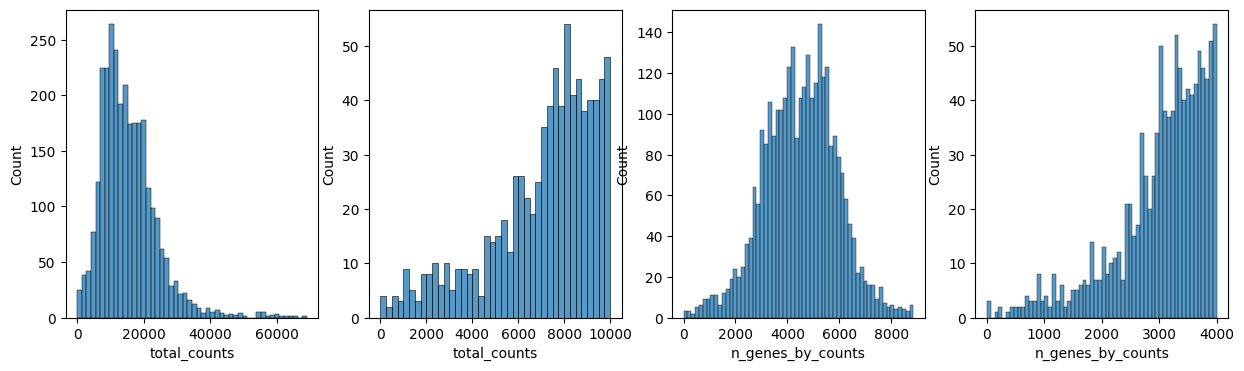

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

Based on the histograms we filter out spots with low read counts or low number of detected genes. We also filter out spots with a high proportion of mitochondrial reads and we remove genes that were detected in less than 10 spots.

In [9]:
sc.pp.filter_cells(adata, min_counts=4500)
sc.pp.filter_cells(adata, min_genes=1500)
sc.pp.filter_genes(adata, min_cells=10)

To properly visualize counts, it is advisable to first normalize the read count in each spot by the total number of reads in this spot, followed by a log transform. However, we do not want to lose the original count data (we will need them later). Fortunately, AnnData has a concept of layers. This means that you can store multiple data matrices for a data set, so we save a copy of our original count matrix to a layer and proceed with normalization.

In [10]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

## Visualizing spatial data
We can now plot the total number of reads per spot. SpatialData's plotting system is very flexible and can plot composites of arbitrary combinations of ojbects. We want to plot the H&E stained tissue image underneath the spots. The `log1p_total_counts` statistic was calculated by `sc.pp.calculate_qc_metrics` above.

In [11]:
sd.transform(sdata.shapes["mousebrain"], sd.transformations.get_transformation(sdata.shapes["mousebrain"], "downscaled_hires"))

geometry    radius
spot_id                                     
0        POINT (1475.232 1249.524)  8.210877
1         POINT (426.619 1446.745)  8.210877
2         POINT (1374.546 458.105)  8.210877
3         POINT (300.559 1094.977)  8.210877
4         POINT (350.960 1182.977)  8.210877
...                            ...       ...
2982       POINT (995.560 677.700)  8.210877
2983      POINT (1159.679 831.671)  8.210877
2984      POINT (717.260 1424.947)  8.210877
2985      POINT (565.596 1468.773)  8.210877
2986      POINT (527.882 1139.150)  8.210877

[2987 rows x 2 columns]

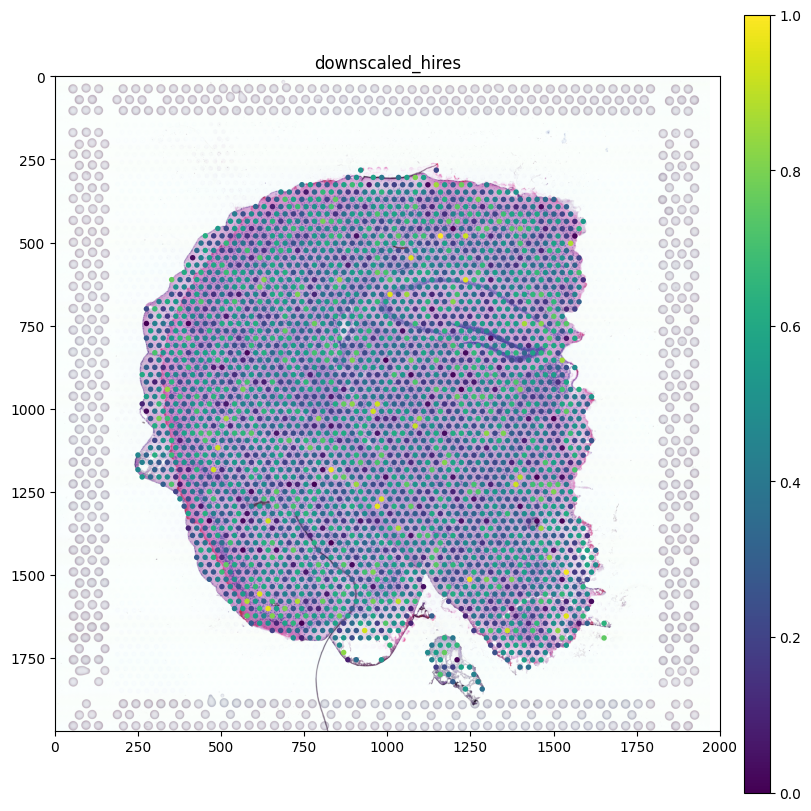

In [12]:
(
    sdata.pl.render_images("mousebrain_hires_image").
         pl.render_shapes(color="log1p_total_counts", fill_alpha=1).
         pl.show("downscaled_hires")
)

We can also look at individual genes. For example, let's look at expression of GABA and dopamine receptors. Gabbr1 is the GABA type B receptor subunit 1 and Drd1 is the D(1a) dopamine receptor.

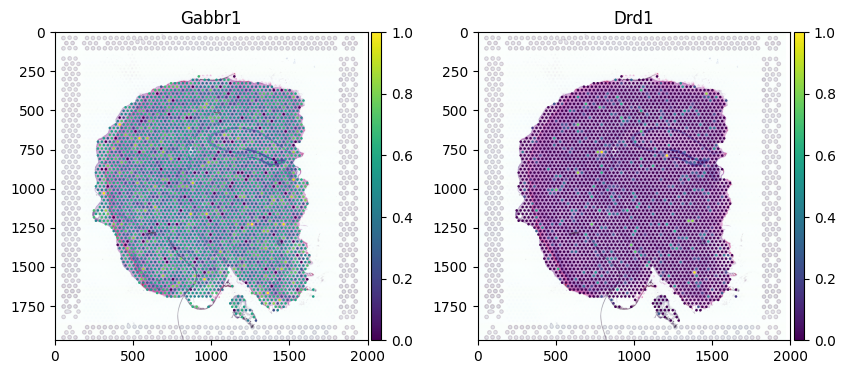

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
for i, gene in enumerate(("Gabbr1", "Drd1")):
    (
        sdata.pl.render_images("mousebrain_hires_image").
             pl.render_shapes(color=gene, fill_alpha=1).
             pl.show("downscaled_hires", ax=axs[i], title=gene)
    )

Suppose we now want to select this cluster of spots with high dopamine receptor expression. Instead of tediously correlating spot indices with coordinates, we can use SquidPy/Napari to interactively select those spots.

In [15]:
sdata.shapes["mousebrain"] = sdata.shapes["mousebrain"][
    sdata.shapes["mousebrain"].index.isin(sdata.table.obs.spot_id)
]

In [16]:
Interactive(sdata)

mousebrain_hires_image: 0.08495402336120605
mousebrain_lowres_image: 0.04536318778991699
mousebrain: 1.9853620529174805


In the viewer window, first select Drd1 from the gene list by double-clicking. Then add a shape layer and rename it to dopamine_receptor. Add a polygon selecting Drd1-expressing spots and press Shift+E. This will save a mask of the spots within the polygon to `.shapes["dopamine_receptor"]`.

In [17]:
polygon = sdata.shapes["dopamine_receptor"]
del sdata.shapes["dopamine_receptor"]

We can now filter the `SpatialData` object to get only the spots covered by the mask.

In [18]:
drep_sdata = sd.polygon_query(sdata, 
                 (sd.transform(polygon,
                               sdata.shapes["mousebrain"].attrs["transform"]["downscaled_hires"].inverse()).geometry[0],),
                 "downscaled_hires")
drep_sdata

SpatialData object with:
├── Shapes
│     └── 'mousebrain': GeoDataFrame shape: (187, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 187 × 17066
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial', 'spatialdata_attrs', 'log1p', 'region_colors'
    obsm: 'spatial'
    layers: 'counts': AnnData (187, 17066)
with coordinate systems:
▸ 'downscaled_hires', with elements:
        mousebrain (Shapes)
▸ 'downscaled_lowres', with elements:
        mousebrain (Shapes)


In [19]:
sdata.table.obs["dopamine_receptor"] = False
sdata.table.obs.loc[drep_sdata.table.obs_names, "dopamine_receptor"] = True
sdata.table.obs["dopamine_receptor"] = pd.Categorical(sdata.table.obs["dopamine_receptor"])

## clustering spatial data
Suppose we want to create a UMAP plot of our data to check if the dopamine-expressing spots are nicely clustered together. The classical workflow consists of selecting variable genes, followed by PCA, k-nearest-neighbors, and finally UMAP. However, we have additional information available, namely spatial coordinates. So instead of just using highly variable genes, we will use genes that are spatially variable. This means that instead of varying randomly across spots, they follow a smooth pattern of variation across the tissue slice (plus some noise). SpatialDE can detect such spatially variable genes, but on large data sets like this ones you ideally would run this on a GPU to get a decent run time. We therefore have precomputed the spatially variable genes for you. You can download the file [here](ftp://ftp.dkfz-heidelberg.de/outgoing/SCCourse2021/ST8059048_svg_full.pkl).

In [20]:
spatially_variable = pd.read_pickle("data/ST8059048_svg_full.pkl")
spatially_variable

gene      time         kappa         nu       U_tilde  \
0                Xkr4  4.575402    165.971038  17.036499  1.397586e+04   
1               Sox17  0.027742     30.547828  16.417408  5.979530e+02   
2              Mrpl15  0.066843    643.617758  15.840952  1.053182e+04   
3               Tcea1  0.078515    490.561791  15.840952  8.577739e+03   
4               Rgs20  0.015914    250.724726  17.495244  3.661584e+04   
...               ...       ...           ...        ...           ...   
12677         mt-Cytb  0.014791  10150.168478  20.032541  4.055169e+06   
12678           Vamp7  0.072417    359.315564  15.840955  1.463586e+04   
12679           Spry3  0.112053     94.855159  15.840952  2.252656e+03   
12680      AC149090.1  0.017502    519.614113  17.241734  4.828150e+04   
12681  CAAA01118383.1  0.017439    158.913517  16.224905  2.892589e+03   

             e_tilde       I_tilde          pval          padj  total_counts  
0        2827.565490  9.385880e+05  7.014123e-11  2.765955e-10         816.0  
1         501.516158  3.064046e+04  2.630273e-01  3.147789e-01         131.0  
2       10195.517969  1.312403e+07  4.167195e-01  4.654604e-01        2497.0  
3        7770.965741  7.624278e+06  3.444157e-01  3.960359e-01        1903.0  
4        4386.490378  2.199603e+06  0.000000e+00  0.000000e+00        1400.0  
...              ...           ...           ...           ...           ...  
12677  203333.663036  4.127742e+09  0.000000e+00  0.000000e+00      587548.0  
12678    5691.901540  4.090378e+06  5.584431e-04  1.191483e-03        1394.0  
12679    1502.596012  2.850580e+05  9.069494e-02  1.249531e-01         368.0  
12680    8959.048492  9.310496e+06  2.221223e-12  9.516741e-12        2785.0  
12681    2578.356708  8.194715e+05  3.262924e-01  3.783178e-01         663.0  

[12682 rows x 10 columns]

We select 2000 most highly expressed spatially variable genes and use those for the PCA.

In [21]:
vargenes = spatially_variable[spatially_variable.padj < 0.001].sort_values("total_counts", ascending=False).gene[:2000]

Before performing PCA we still need to remove the influence of total number of reads per spot on the expression. Although we have already normalized the data using `sc.pp.normalize_total`, which divides counts for each gene by the total number of reads in a spot, this very simple normalization is often not sufficient to remove all artifacts associated with different total read counts. `sc.pp.regress_out` performs a linear regression for each gene using the total read counts per spot as a predictor, and uses the residuals from that regression as new expression values.

/home/ilia/Documents/Uni/Uni/PostDoc 2 Stegle/teaching/single cell course/venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/home/ilia/Documents/Uni/Uni/PostDoc 2 Stegle/teaching/single cell course/venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


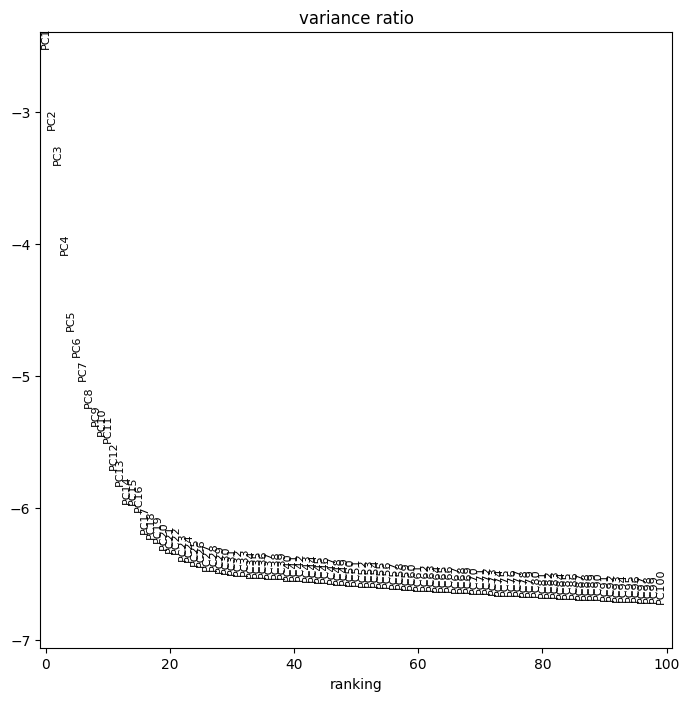

In [22]:
adata_variable = adata[:, vargenes]
sc.pp.regress_out(adata_variable, ['total_counts'])
sc.pp.pca(adata_variable, n_comps=100)
sc.pl.pca_variance_ratio(adata_variable, log=True, n_pcs=100)

We create a k-nearest-neighbors in the PCA space and use it to create a UMAP, which will be colored by whether a spot belongs to our set of spots with high dopamine receptor expression.

/home/ilia/Documents/Uni/Uni/PostDoc 2 Stegle/teaching/single cell course/venv/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


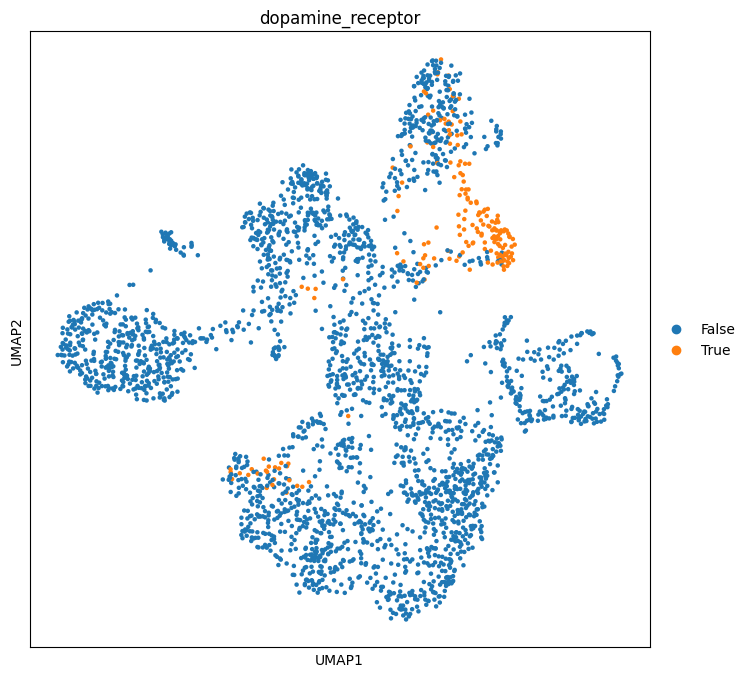

In [23]:
sc.pp.neighbors(adata_variable, n_neighbors=20, n_pcs=80)
sc.tl.umap(adata_variable)
sc.pl.umap(adata_variable, color="dopamine_receptor")

So the dopamine expressing cells are located close together in gene expression space, which suggests that this is a brain region that responds to dopamine. Suppose we now want segment our entire data set into distinct regions. We could of course do what we just did: manually look through lots of genes and manually select the corresponding regions. However, that approach is tedious, irreproducible, and can potentiall overlook things. The development version of SpatialDE implements a segmentation method that groups spots by their expression, but encourages the clusters to be spatially smooth, i.e. neighboring spots should belong to the same cluster. This method is probabilistically motivated and works on raw counts, so we let it loose on the `counts` layer that we created previously.

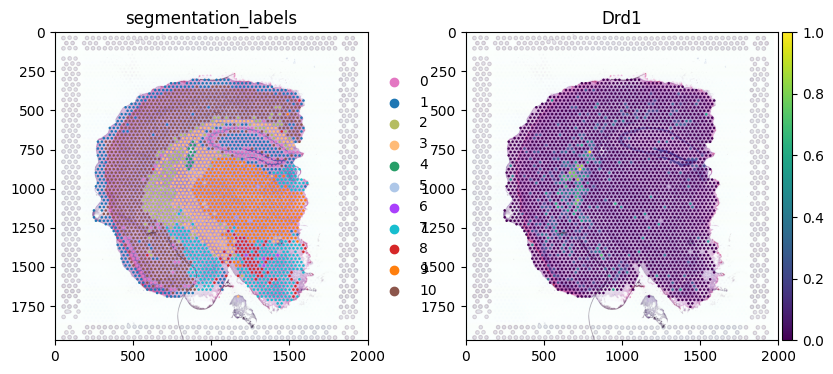

In [25]:
segmentation, _ = SpatialDE.tissue_segmentation(adata, genes=vargenes, layer="counts", rng=np.random.default_rng(seed=42))
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
for i, toplot in enumerate(("segmentation_labels", "Drd1")):
    (
        sdata.pl.render_images("mousebrain_hires_image").
             pl.render_shapes(color=toplot, size=0.3, fill_alpha=1).
             pl.show("downscaled_hires", ax=axs[i], title=toplot)
    )

As we can see, our dopamine-receptor-expressing spots are all clustered into the same cluster, but we also uncover distinct clusters in other brain regions. We can compare SpatialDE's results to a standard Leiden clustering, run on the k-nearest-neighbors graph we created previously.

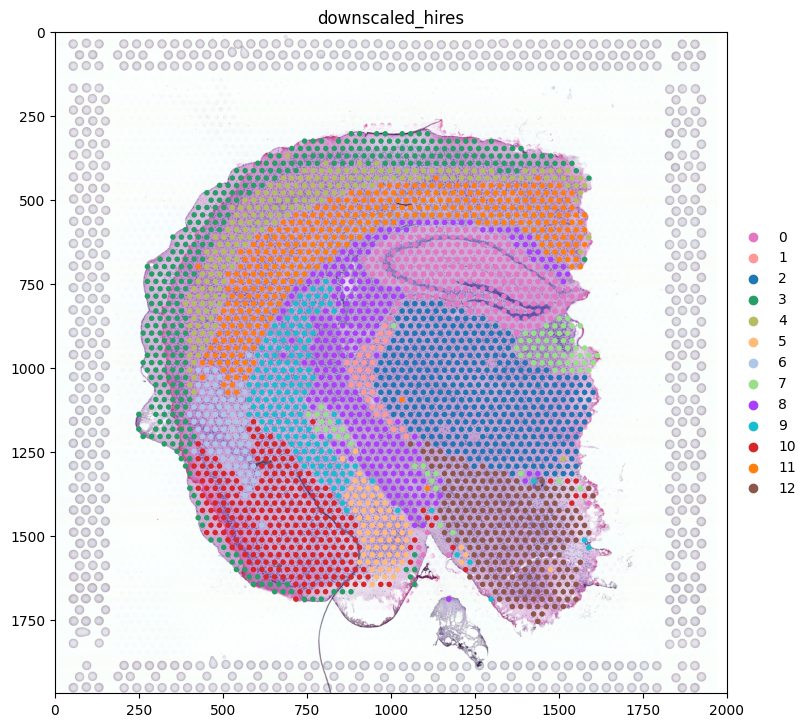

In [26]:
sc.tl.leiden(adata_variable, random_state=42)
sdata.table.obs["leiden"] = adata_variable.obs.leiden
(
    sdata.pl.render_images("mousebrain_hires_image").
             pl.render_shapes(color="leiden", fill_alpha=1).
             pl.show("downscaled_hires")
)

Leiden seems to resolve some areas better than SpatialDE, e.g. the layered structure of the isocortex, but some worse, e.g. the hippocampus. We can look at UMAPs colored by the two segmentations:

/home/ilia/Documents/Uni/Uni/PostDoc 2 Stegle/teaching/single cell course/venv/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ilia/Documents/Uni/Uni/PostDoc 2 Stegle/teaching/single cell course/venv/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


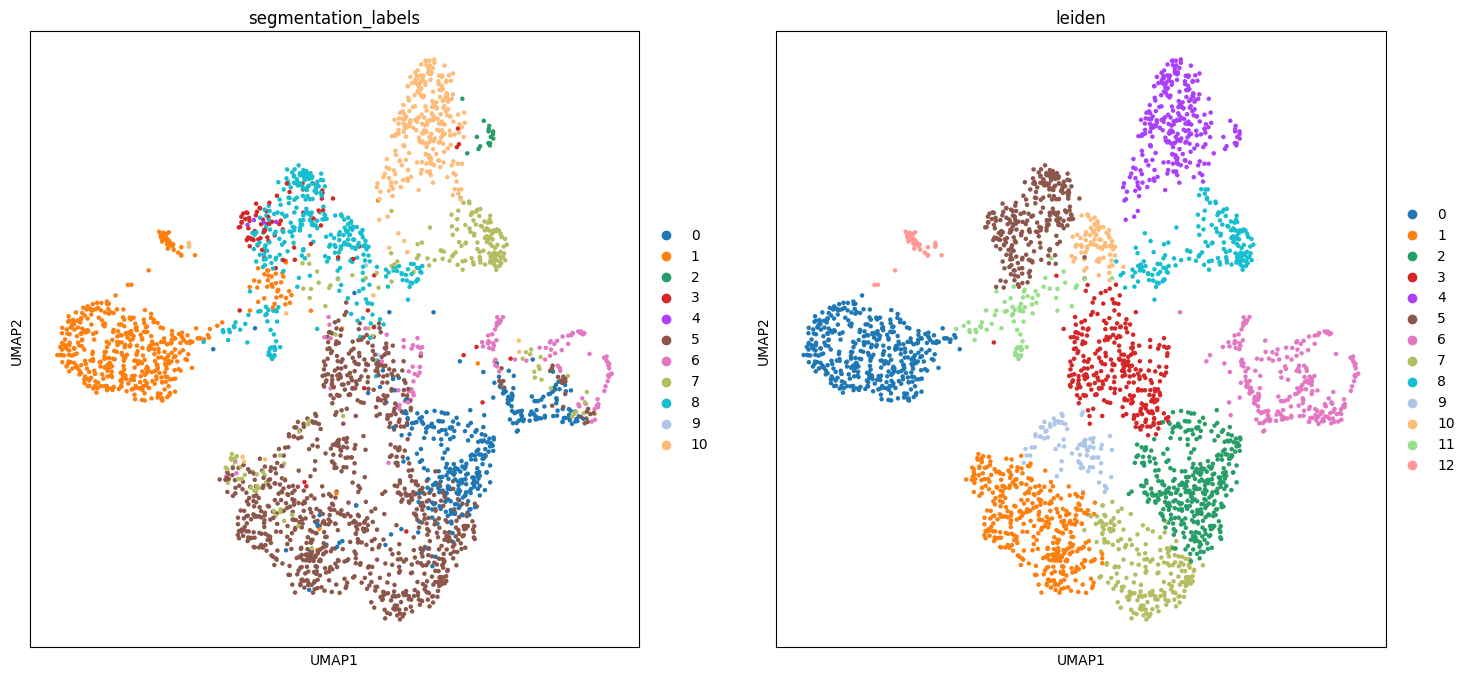

In [27]:
adata_variable.obs["segmentation_labels"] = adata.obs.segmentation_labels
sc.pl.umap(adata_variable, color=["segmentation_labels", "leiden"])

As expected, Leiden clusters correspond solely to distance in gene expression space. The hippocampus in particular looks like one cluster in gene expression space, possibly because the number of spots covering pyramidal neurons is so low.

We can increase SpatialDE's resolution by tweaking the spatial smoothness penalty. With reduced penalty (corresponding to a larger `smoothness_factor`), SpatialDE also recovers the layered structure of the isocortex, plus some additional details.

In [28]:
segmentation, _ = SpatialDE.tissue_segmentation(adata,
                                                genes=vargenes,
                                                layer="counts",
                                                rng=np.random.default_rng(seed=42),
                                                params=SpatialDE.TissueSegmentationParameters(smoothness_factor=5))

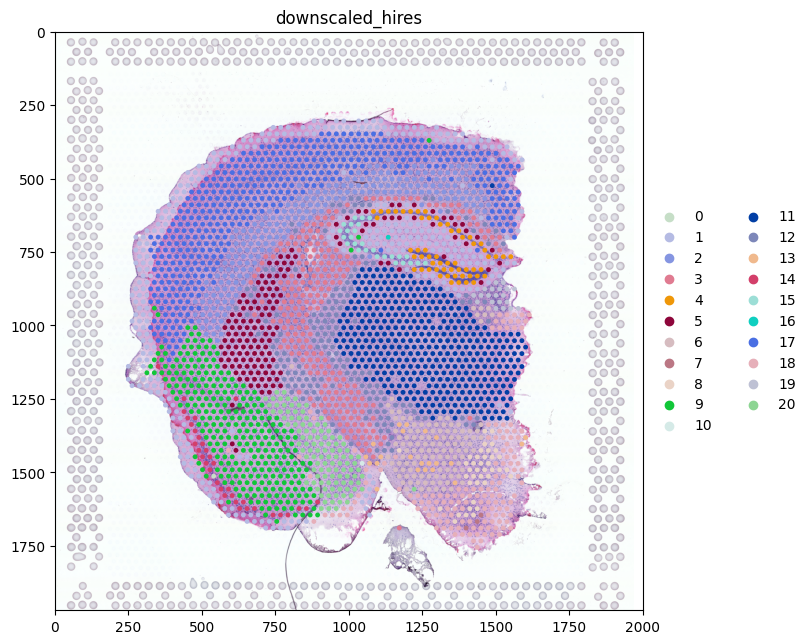

In [29]:
(
    sdata.pl.render_images("mousebrain_hires_image").
             pl.render_shapes(color="segmentation_labels", fill_alpha=1).
             pl.show("downscaled_hires")
)

## deconvolving cell types with cell2location
10x Visium is not a single-cell technology, each spot contains approx. 10-50 cells, which can belong to different cell types. Deconvolution methods use a single-cell reference data set to model each spot as a mixture of cell types. We will use [cell2location](https://doi.org/10.1038/s41587-021-01139-4) to illustrate deconvolution of the mouse brain data set. The single-cell reference can be downloaded [here](https://cell2location.cog.sanger.ac.uk/tutorial/mouse_brain_snrna/all_cells_20200625.h5ad) and the cell type assignment [here](https://cell2location.cog.sanger.ac.uk/tutorial/mouse_brain_snrna/snRNA_annotation_astro_subtypes_refined59_20200823.csv).

First, we read the reference, merge the cell type information, and remove low-quality genes. In particular, we remove all genes that are expressed in less than 50 cells, and genes that are expressed in more than 50 cells but less than 5% of the total number of cells are included only if their average expression is above 1.15.

/home/ilia/Documents/Uni/Uni/PostDoc 2 Stegle/teaching/single cell course/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


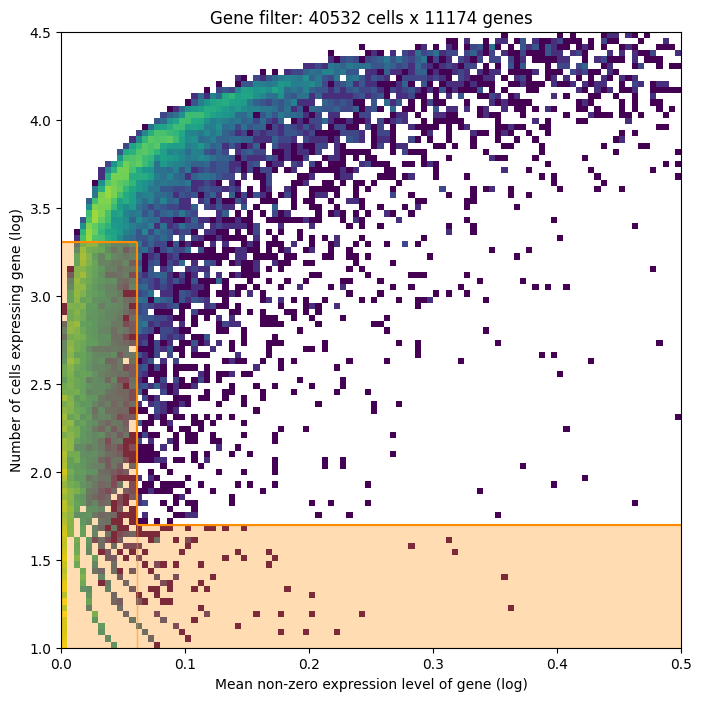

In [30]:
adata_ref = ad.read_h5ad("data/all_cells_20200625.h5ad")
celltypes = pd.read_csv("data/snRNA_annotation_astro_subtypes_refined59_20200823.csv", index_col=0).rename({"annotation_1": "celltype"}, axis=1)
celltypes.celltype = pd.Categorical(celltypes.celltype)
adata_ref = adata_ref[celltypes.index, :]
adata_ref.obs = pd.concat([adata_ref.obs, celltypes], axis=1, join="inner")
selected = filter_genes(adata_ref, cell_count_cutoff=50, cell_percentage_cutoff2=0.05, nonz_mean_cutoff=1.15)
adata_ref = adata_ref[:, selected].copy()

We now estimate the reference expression signatures. The model used by cell2location takes batch and technical effects into account, which is important as our reference was built from 6 separate samples. This takes quite some time, so we already trained the model.

In [31]:
RegressionModel.setup_anndata(adata=adata_ref,
                        batch_key='sample',
                        labels_key='celltype'
                       )
mod = RegressionModel(adata_ref)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.3.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': 'celltype',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   6   │
│         n_cells          │ 40532 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  59   │
│          n_vars          │ 11174 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃   Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ 5705STDY8058280 │          0          │
│                     │ 5705STDY8058281 │          1          │
│                     │ 5705STDY8058282 │          2          │
│                     │ 5705STDY8058283 │          3          │
│                     │ 5705STDY8058284 │          4          │
│                     │ 5705STDY8058285 │          5          │
└─────────────────────┴─────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['celltype'] │   Astro_AMY    │          0          │
│                       │ Astro_AMY_CTX  │          1          │
│                       │   Astro_CTX    │          2          │
│                       │   Astro_HPC    │          3          │
│                       │   Astro_HYPO   │          4          │
│                       │   Astro_STR    │          5          │
│                       │ Astro_THAL_hab │          6          │
│                       │ Astro_THAL_lat │          7          │
│                       │ Astro_THAL_med │          8          │
│                       │    Astro_WM    │          9          │
│                       │      Endo      │         10          │
│                       │   Ext_Amy_1    │         11          │
│                       │   Ext_Amy_2    │         12          │
│                       │  Ext_ClauPyr   │         13          │
│                       │  Ext_Hpc_CA1   │         14          │
│                       │  Ext_Hpc_CA2   │         15          │
│                       │  Ext_Hpc_CA3   │         16          │
│                       │  Ext_Hpc_DG1   │         17          │
│                       │  Ext_Hpc_DG2   │         18          │
│                       │    Ext_L23     │         19          │
│                       │    Ext_L25     │         20          │
│                       │    Ext_L56     │         21          │
│                       │    Ext_L5_1    │         22          │
│                       │    Ext_L5_2    │         23          │
│                       │    Ext_L5_3    │         24          │
│                       │     Ext_L6     │         25          │
│                       │    Ext_L6B     │         26          │
│                       │    Ext_Med     │         27          │
│                       │    Ext_Pir     │         28          │
│                       │   Ext_Thal_1   │         29          │
│                       │   Ext_Thal_2   │         30          │
│                       │   Ext_Unk_1    │         31          │
│                       │   Ext_Unk_2    │         32          │
│                       │   Ext_Unk_3    │         33          │
│                       │     Inh_1      │         34          │
│                       │     Inh_2      │         35          │
│                       │     Inh_3      │         36          │
│                       │     Inh_4      │         37          │
│                       │     Inh_5      │         38          │
│                       │     Inh_6      │         39          │
│                       │   Inh_Lamp5    │         40          │
│                       │  Inh_Meis2_1   │         41          │
│                       │  Inh_Meis2_2   │         42          │
│                       │  Inh_Meis2_3   │         43          │
│                       │  Inh_Meis2_4   │         44          │
│                       │   Inh_Pvalb    │         45          │
│                       │    Inh_Sst     │         46          │
│                       │    Inh_Vip     │         47          │
│                       │     LowQ_1     │         48          │
│                       │     LowQ_2     │         49          │
│                       │     Micro      │         50          │
│                       │      Nb_1      │         51          │
│                       │      Nb_2      │         52          │
│                       │     OPC_1      │         53          │
│                       │     OPC_2      │         54          │
│                       │    Oligo_1     │         55          │
│                       │    Oligo_2     │         56          │
│                       │     Unk_1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/ilia/envs/sccourse/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Epoch 500/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [15:25<00:00,  1.84s/it, v_num=1, elbo_train=2.44e+8]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [15:25<00:00,  1.85s/it, v_num=1, elbo_train=2.44e+8]


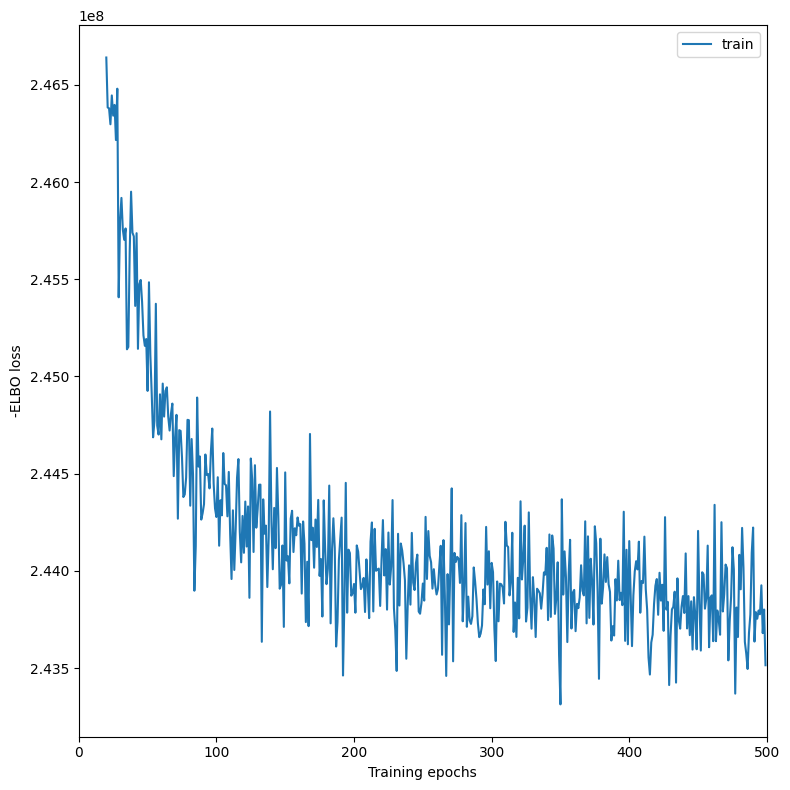

In [30]:
mod = RegressionModel(adata_ref)
mod.train(max_epochs=500, batch_size=2500, train_size=1, lr=0.001, use_gpu=True)
mod.plot_history(20)

In [31]:
mod.save("data/reference_signatures", overwrite=True)

In [26]:
mod = RegressionModel.load("data/reference_signatures", adata_ref)

INFO     File data/reference_signatures/model.pt already downloaded                          
INFO     Preparing underlying module for load                                                


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/data/ilia/practical/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/493:   0%|                                                                                                                                                                     | 0/493 [00:00<?, ?it/s]

/data/ilia/practical/lib/python3.7/site-packages/torch/distributions/gamma.py:71: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/kats/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)


Epoch 1/493:   0%|▎                                                                                                                               | 1/493 [00:01<09:39,  1.18s/it, v_num=1, elbo_train=2.49e+8]


We can now use the trained model to estimate gene expression signatures for our cell types and assess predictive performance of the trained model. Parameter estimation requires sampling from the posterior distribution of the model, so it takes some time and a lot of memory. We therefore provde precomputed results.

In [32]:
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 10000, 'batch_size': 2500, 'use_gpu': True}
)
adata_ref.write("data/all_cells_20200625_c2l.h5ad", compression="gzip", compression_opts=9)

Sampling global variables, sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [01:11<00:00, 140.71it/s]


We can now do some quality control of our model. The first plot compares posterior estimates of gene expression ($\mu_{c,g}$ in the cell2location paper) to actual gene expression. The second plot compares the estimated cell type signatures ($g_{f,g}$ in the cell2location paper) to a simple average of all cells of cell type $f$.

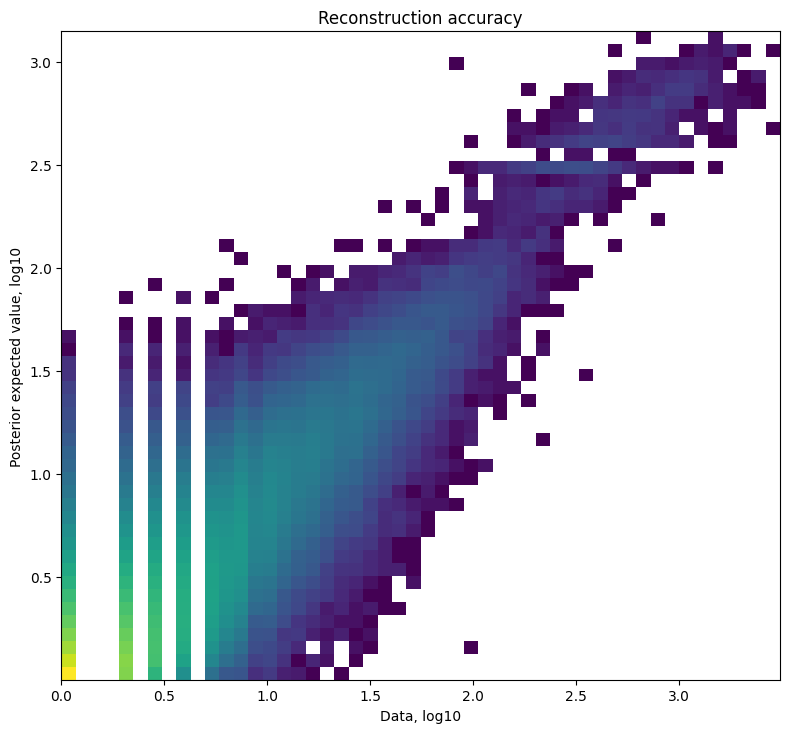

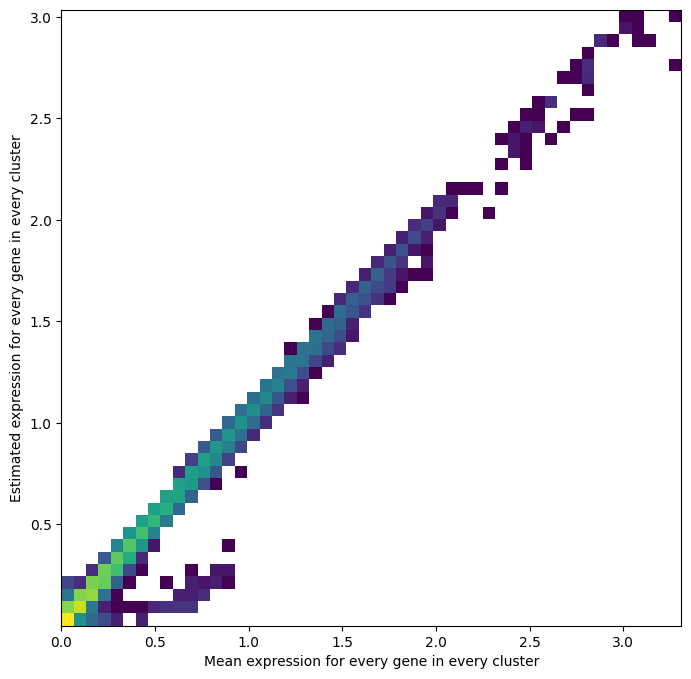

In [33]:
mod.plot_QC()

In [35]:
adata_ref = ad.read_h5ad("data/all_cells_20200625_c2l.h5ad")

We now have to subset our reference and spatial data sets to contain only genes that were detected in both. Then we can configure and train our cell2location model.

In [36]:
inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]]
inf_aver.columns = adata_ref.uns['mod']['factor_names']
                                 
intersect = adata_ref.var_names.intersection(adata.var.gene_ids)

adata_vis = adata[:, adata.var.gene_ids.isin(intersect)].copy()
inf_aver = inf_aver.loc[intersect, :]
adata_vis.var = adata_vis.var.reset_index().rename(columns={"index": "gene_name"}).set_index("gene_ids")
Cell2location.setup_anndata(adata_vis, layer="counts")
mod = Cell2location(
                    adata_vis,
                    cell_state_df=inf_aver,
                    N_cells_per_location=30)
mod.view_anndata_setup()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Anndata setup with scvi-tools version 0.20.3.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 2871  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 10613 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [37]:
mod.train(max_epochs=30000,
          batch_size=None,
          train_size=1,
          use_gpu=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/ilia/envs/sccourse/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
/data/ilia/envs/sccourse/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of

Epoch 30000/30000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [28:47<00:00, 17.25it/s, v_num=1, elbo_train=2.84e+7]

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [28:47<00:00, 17.37it/s, v_num=1, elbo_train=2.84e+7]


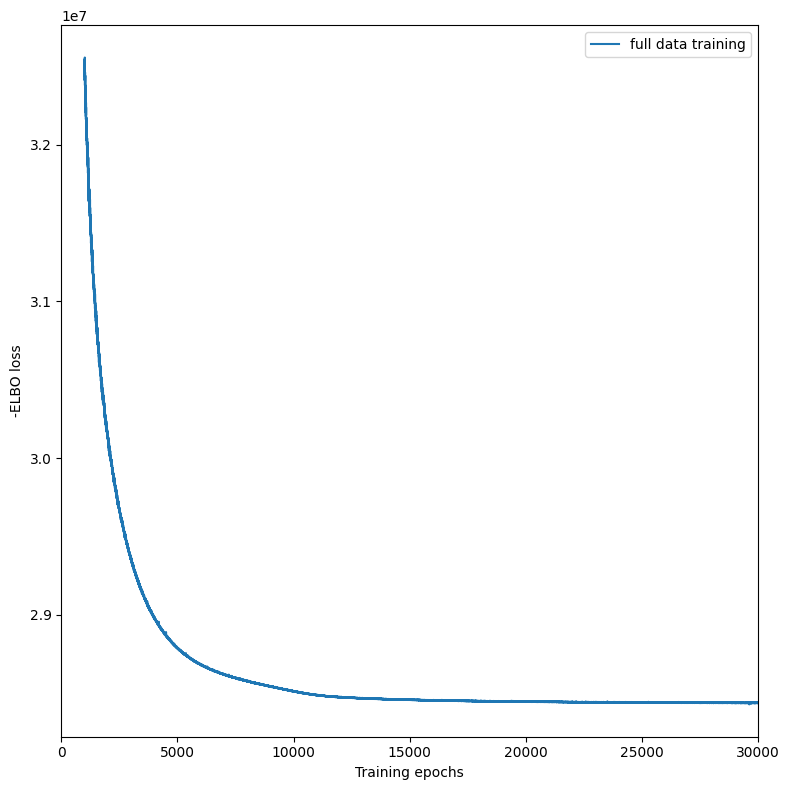

In [38]:
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [39]:
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 10000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)
mod.save("data/cell2location_model", overwrite=True)
adata_vis.write("data/mouse_brain.h5ad", compression="gzip", compression_opts=9)

Sampling global variables, sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [02:19<00:00, 71.81it/s]


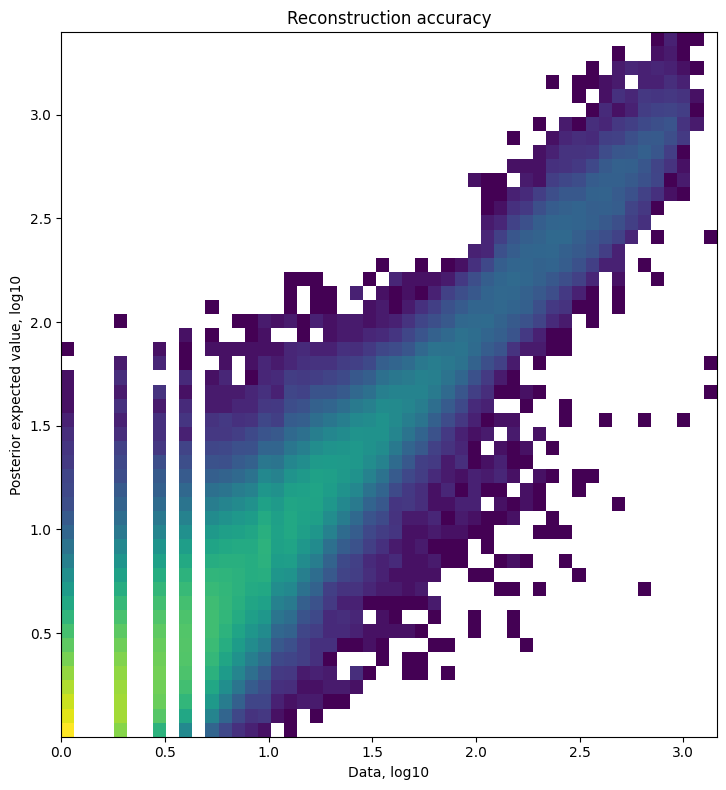

In [40]:
mod.plot_QC()

In [31]:
adata_vis = ad.read_h5ad("data/mouse_brain.h5ad")

In [33]:
mod = cell2location.models.Cell2location.load("data/cell2location_model", adata_vis)

INFO     File data/cell2location_model/model.pt already downloaded                                                 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ilia/Documents/Uni/Uni/PostDoc 2 Stegle/teaching/single cell course/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/home/ilia/Documents/Uni/Uni/PostDoc 2 Stegle/teaching/single cell course/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/30000:   0%|                                                                                                                                                                       | 1/30000 [00:02<17:36:36,  2.11s/it, v_num=1, elbo_train=8.42e+7]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/30000:   0%|                                                                                                                                                                       | 1/30000 [00:02<17:39:01,  2.12s/it, v_num=1, elbo_train=8.42e+7]


Now we can plot the spatial distribution of cell types of interest

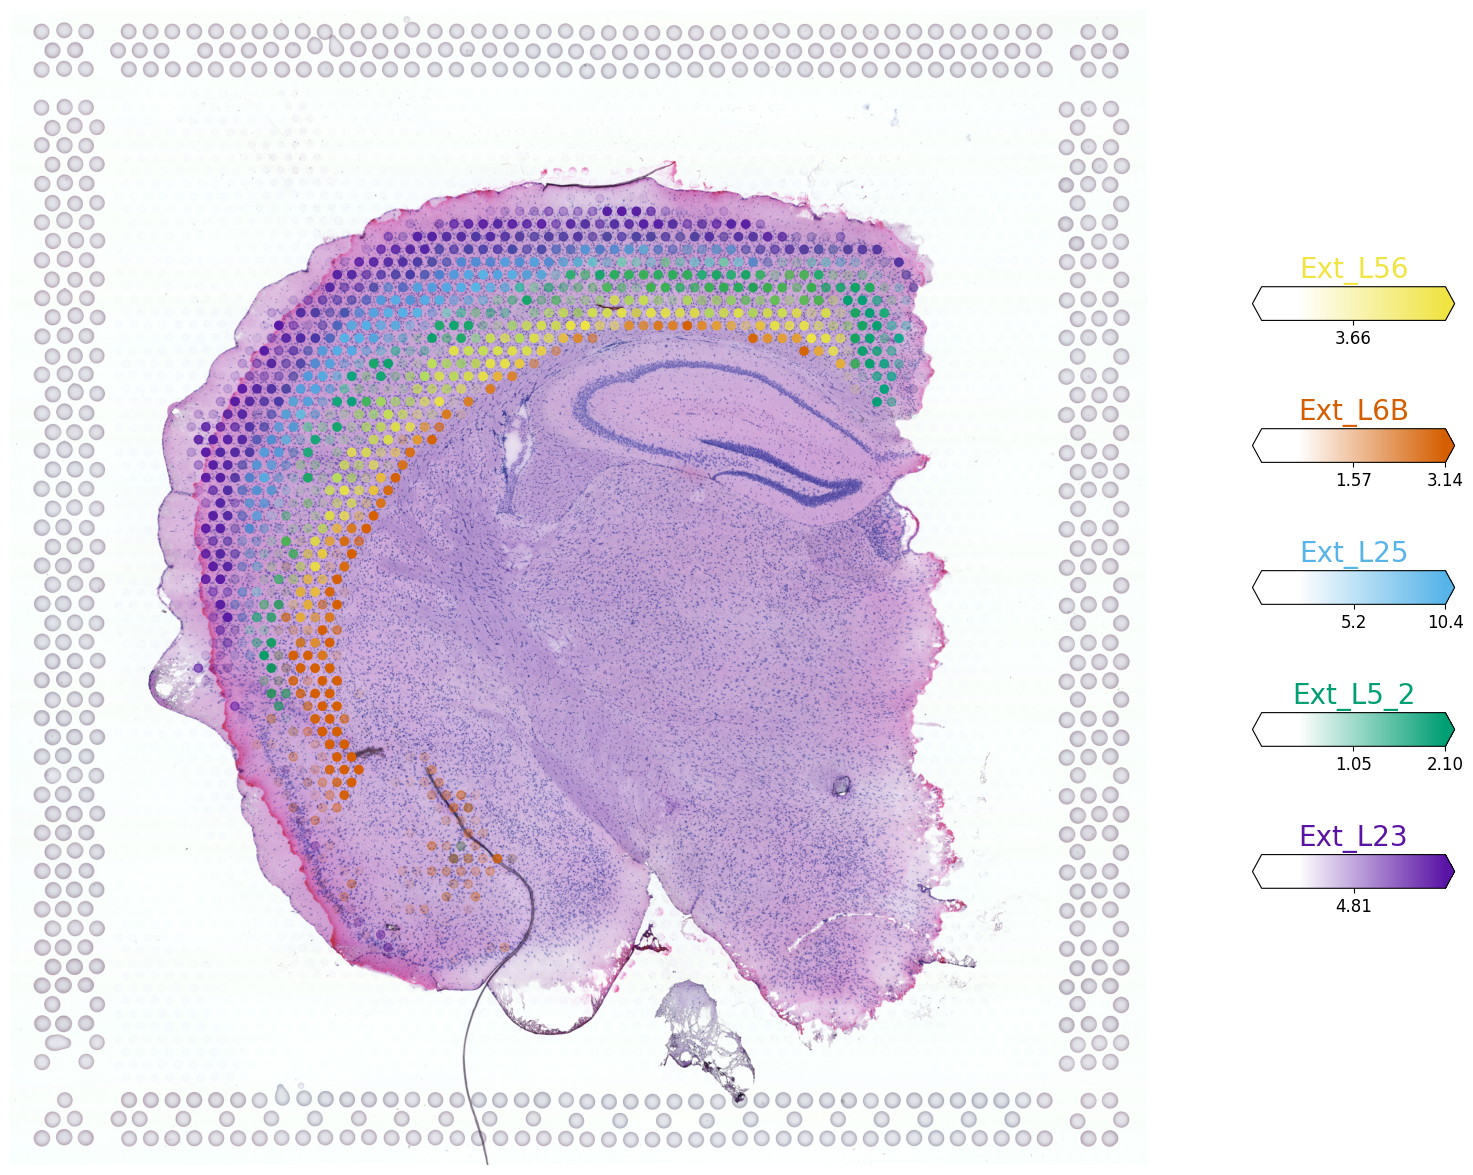

In [34]:
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']
with mpl.rc_context({'figure.figsize': (20, 15)}):
    plot_spatial(adata_vis,
                 color=["Ext_L56", "Ext_L6B", "Ext_L25", "Ext_L5_2", "Ext_L23"],
                 labels=["Ext_L56", "Ext_L6B", "Ext_L25", "Ext_L5_2", "Ext_L23"],
                 circle_diameter=6,
                 colorbar_position='right')

## extracting image features
Sometimes, one would like to include features features from the corresponding tissue images in one's analysis. SquidPy contains several functions that can extract classical computer vision features from an image, but we will use a different approach here. We will use a neural network, pre-trained to classify the ImageNet data set, without its top classification layer. The neuron activations of the second-to-last layer (i.e. the layer immediately preceding the classification layer) will be our features.

SpatialData provides a handy function to generate image crops surrounding each spot. We first get the radius of the Visium spots.

In [35]:
visium_circles_diameter = 2 * sdata["mousebrain"].radius[0]

In [36]:
dataset = sd.dataloader.ImageTilesDataset(sdata,
                                          {"mousebrain": "mousebrain_hires_image"},
                                          tile_dim_in_units=1.5 * visium_circles_diameter,
                                          tile_dim_in_pixels=1.5 * visium_circles_diameter * sd.transformations.get_transformation(sdata.shapes["mousebrain"], "downscaled_hires").scale[0],
                                          target_coordinate_system="downscaled_hires"
                                         )

In [37]:
import torch
from torchvision.models import resnet50
resnet = resnet50(weights="IMAGENET1K_V2")

In [38]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [39]:
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))

In [40]:
resnet

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [41]:
dloader = torch.utils.data.DataLoader([tile.images["mousebrain_hires_image"].to_numpy() for tile in dataset],
                                      batch_size=sdata.shapes["mousebrain"].shape[0])

In [42]:
data = next(iter(dloader))

In [43]:
resnet.eval()
features = resnet(data.to(torch.float32)).detach().numpy().squeeze()

In [44]:
features

array([[18.942566 ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 6.6707993,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 4.2675323,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [12.96703  ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [18.158962 ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)

In [45]:
features.shape

(2871, 2048)

In [46]:
np.sum(features > 0)

302176

In [47]:
features[features > 0]

array([ 18.942566, 133.7932  ,  21.272179, ..., 116.485565,  42.19028 ,
        14.494503], dtype=float32)

In [48]:
features = sparse.csr_matrix(features)

## working with multimodal data
We could force the features matrix into our original AnnData object, e.g. by using the `obsm` slot, but that wouldn't really be useful. Instead, we can create a second AnnData object holding the image features, and group the two AnnData objects together. For this, we will use [muon](https://muon.readthedocs.io), a new package to make working with multi-modal data sets easier.

In [49]:
features = ad.AnnData(X=features, obs=pd.DataFrame(index=adata.obs_names))
mu.set_options(display_style="html")

In [50]:
multim = mu.MuData({"visium": adata, "resnet_features": features})

In [51]:
multim

MuData object with n_obs × n_vars = 2871 × 19114
  2 modalities
    visium:	2871 x 17066
      obs:	'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'dopamine_receptor', 'segmentation_labels', 'leiden'
      var:	'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
      uns:	'spatial', 'spatialdata_attrs', 'log1p', 'region_colors', 'segmentation_labels_colors', 'leiden_colors'
      obsm:	'spatial', 'segmentation_class_probabilities'
      layers:	'counts'
    resnet_features:	2871 x 2048

## finding smooth spatial factors with MEFISTO
MEFISTO is an extension of MOFA that imposes a spatial smoothness constraint on the factors. It is implemented using Gaussian processes. Here we will use MEFISTO to identify smooth factors in the mouse brain tissue.

We first create a MOFA object and set all the required options.

In [52]:
from mofapy2.run.entry_point import entry_point
ent = entry_point()
ent.set_data_options(use_float32=True)
ent.set_data_from_anndata(adata_variable)
ent.set_model_options(factors=4)
ent.set_train_options(seed=42)
ent.set_covariates([adata.obsm["spatial"]], covariates_names=["x", "y"])
ent.set_smooth_options(sparseGP=True, frac_inducing=0.3, start_opt=10, opt_freq=10)
ent.build()


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
use_float32 set to True: replacing float64 arrays by float32 arrays to speed up computations...

Loaded view='rna' group='group1' with N=2871 samples and D=2000 features...


Model options:
- Automatic Relevance Determination prior on the factors: False
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab pr

We the train the model and save the results. Training takes quite some time, so we provide a pre-trained model.

In [118]:
ent.run()
ent.save("data/ST8059048_MEFISTO.h5")



######################################
## Training the model with seed 42 ##
######################################


ELBO before training: -22257797.92 

Iteration 1: time=1.75, ELBO=-4548065.19, deltaELBO=17709732.729 (79.56641890%), Factors=4
Iteration 2: time=1.64, ELBO=-4341672.33, deltaELBO=206392.861 (0.92728338%), Factors=4
Iteration 3: time=1.66, ELBO=-4328451.67, deltaELBO=13220.659 (0.05939788%), Factors=4
Iteration 4: time=1.65, ELBO=-4322963.52, deltaELBO=5488.145 (0.02465718%), Factors=4
Iteration 5: time=1.78, ELBO=-4319266.42, deltaELBO=3697.104 (0.01661038%), Factors=4
Iteration 6: time=1.80, ELBO=-4317211.94, deltaELBO=2054.478 (0.00923038%), Factors=4
Iteration 7: time=1.75, ELBO=-4316324.10, deltaELBO=887.835 (0.00398887%), Factors=4
Iteration 8: time=1.74, ELBO=-4315898.54, deltaELBO=425.560 (0.00191196%), Factors=4
Iteration 9: time=1.82, ELBO=-4315597.86, deltaELBO=300.686 (0.00135092%), Factors=4
Optimising sigma node...
Iteration 10: time=67.77, ELBO=-4258833

We use the mofax package to access the trained model. We first load the model and plot the correlation between factors. Ideally, it should be 0.

<Axes: >

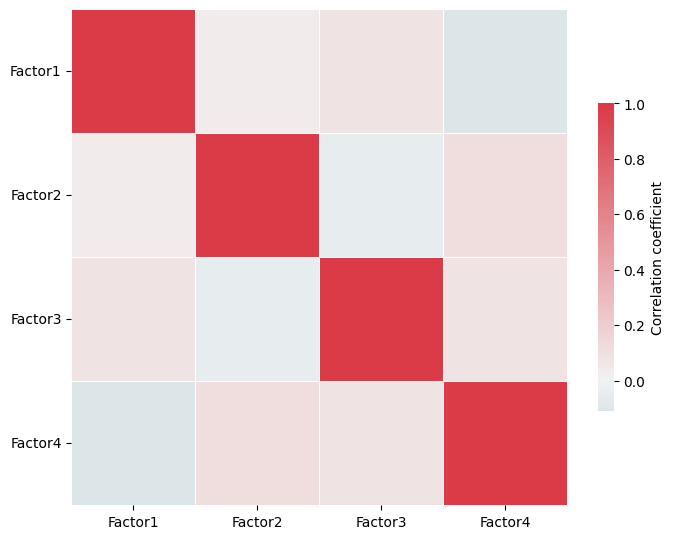

In [53]:
m = mofax.mofa_model("data/ST8059048_MEFISTO.h5")
mofax.plot_factors_correlation(m)

We can also plot the individual factors:

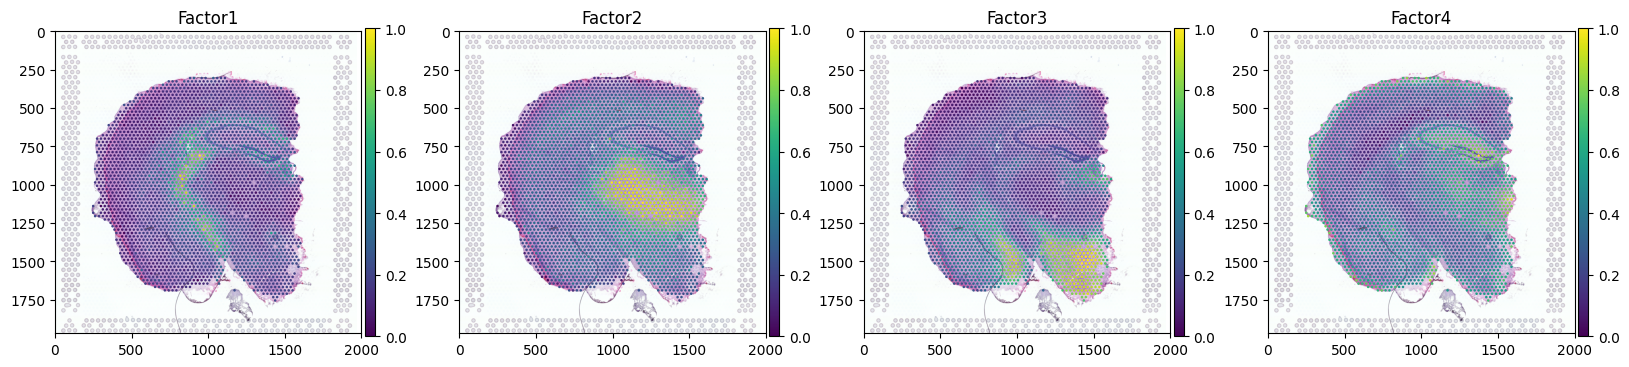

In [54]:
adata.obs = adata.obs.join(m.get_factors(df=True))
fig, axs = plt.subplots(ncols=4, figsize=(20, 4))
for i in range(4):
    (
        sdata.pl.render_images("mousebrain_hires_image").
             pl.render_shapes(color=f"Factor{i+1}", size=0.3, fill_alpha=1).
             pl.show("downscaled_hires", ax=axs[i], title=f"Factor{i+1}")
    )

We can also look at the fraction of variance attributed to structured spatial variation vs. random nose for each factor:

<Axes: xlabel='Smoothness', ylabel='Factor'>

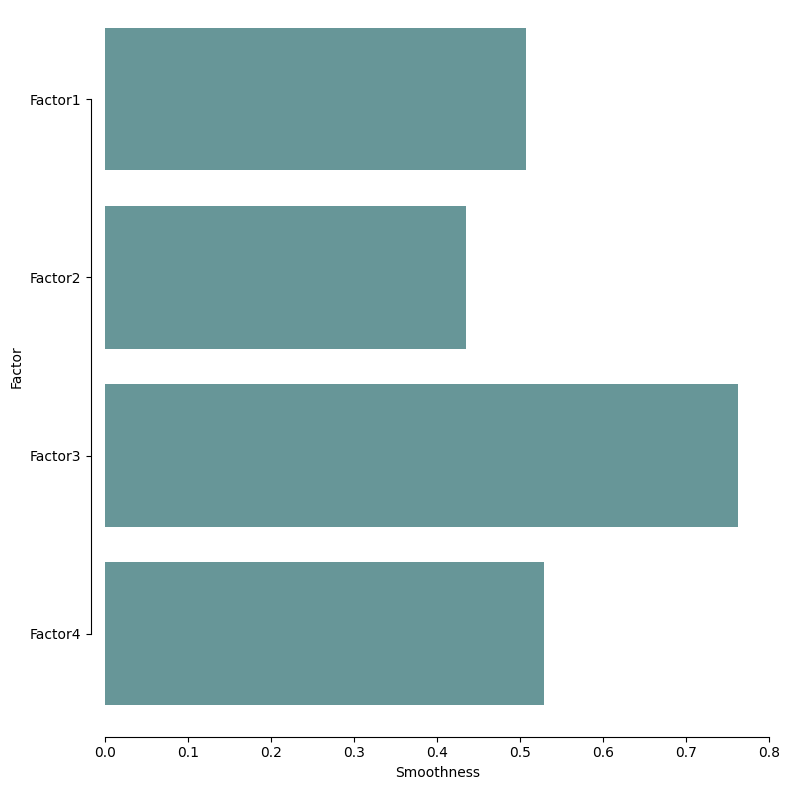

In [55]:
mofax.plot_smoothness(m)

Finally, we can get genes with the highest weights for factor 2 and look at their expression.

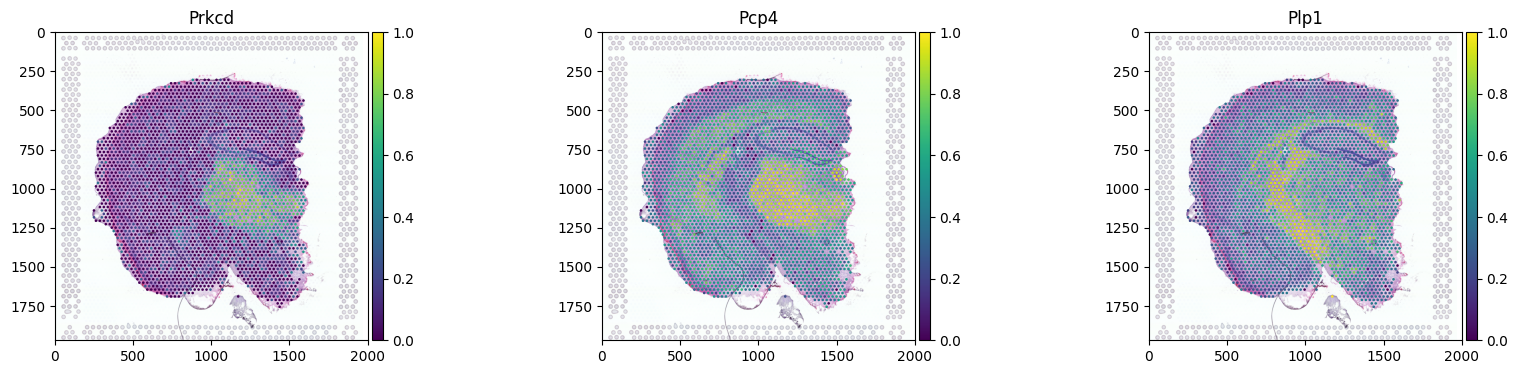

In [56]:
top_features_f2 = m.get_top_features(factors="Factor2", n_features=3)
fig, axs = plt.subplots(ncols=len(top_features_f2), figsize=(20, 4))
for i, feat in enumerate(top_features_f2):
    (
        sdata.pl.render_images("mousebrain_hires_image").
             pl.render_shapes(color=feat, size=0.3, fill_alpha=1).
             pl.show("downscaled_hires", ax=axs[i], title=feat)
    )

# exercises
## variable genes
Compare the spatially variable genes by SpatialDE with the highly variable genes generated by Scanpy.

## clustering
### cluster by cell type composition
Cell2location also computes a posterior estimate of the UMI count per cell type for each spot. Try to figure out where this is stored in the AnnData object and apply SpatialDE and Leiden clustering to it. Compare with clustering in gene expression space.

### Image features
Perform Leiden clustering on the image features and compare it to the clustering in gene expression space.

### Joint clustering of gene expression and image features
Muon provides a multimodal version of the Leiden clustering algorithm. See if you can get better results by including image features in the clustering. You should also try to use Muon's weighted nearest neighbors implementation to generate UMAPs based on both gene expression and image features. Also try to extract different image features, either using a different pre-trained network, or another package such as scikit-image or SquidPy, and compare the clusterings.

## smooth factorization
MEFISTO can also work with multiple data types (called views). Muon provides a convenient interface for this functionality. Fit a MEFISTO model to both RNA and image features and compare the factors.

# additional resources
## tutorials
- [Best practices for single-cell RNA-seq analysis (non-spatial)](https://www.embopress.org/doi/full/10.15252/msb.20188746)
- [Best practices for multi-modal single-cell analysis](https://www.nature.com/articles/s41576-023-00586-w)
- [Scanpy tutorials](https://scanpy-tutorials.readthedocs.io/en/latest/)
- [muon tutorials](https://muon-tutorials.readthedocs.io/en/latest/)
- [MEFISTO tutorials](https://github.com/bioFAM/MEFISTO_tutorials)
- [SpatialData tutorials](https://spatialdata.scverse.org/en/latest/tutorials/notebooks/notebooks.html)

## reference documentation
- [Scanpy](https://scanpy.readthedocs.io/en/stable/)
- [muon](https://muon.readthedocs.io/en/latest/)
- [SpatialData](https://spatialdata.scverse.org/en/latest/index.html)